In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.4. Clustering Analyses/1.4.1. Kmeans Clustering/1.4.1.5. Baseline Eigencytokines & Weights/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.4. Clustering Analyses/1.4.1. Kmeans Clustering/1.4.1.5. Baseline Eigencytokines & Weights/Output')
cur_date = "121121"

library(readxl)
library(dplyr)
library(tidyverse)
require(reshape2)
library(patchwork)

#reading in files
eigencytokines_NLF = read_csv("eigencytokines_NLF.csv") %>%
    rename(SubjectID = X1)
NLF_clus <- data.frame(read_excel("011921NLF_cluster_assignments.xlsx")) %>%
    rename(Protein = Cytokine)
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))
eigenvector_weights = read_csv("042121_eigenvector_weights.csv") %>%
    filter(Dataset == 'Original', Compartment == 'NLF')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: reshape2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  ClusterA = col_double(),
  ClusterB = col_double(),
  ClusterC = col_double()
)



── Column specification ───────────

In [2]:
#for the eigencytokines renaming the value to Conc_pslog2 is a bit misleading, but I did it to allow the full join 
#to work
#renaming cluster to name to make the final df
# eigencytokines df and splitting by cluster
eigencytokines_NLF = reshape2::melt(eigencytokines_NLF, variable = "Name", value.name = "Conc_pslog2") %>%
    group_by(Name) %>%
    group_split

eigencytokines_NLF_ClusterA = eigencytokines_NLF[[1]]
eigencytokines_NLF_ClusterB = eigencytokines_NLF[[2]]
eigencytokines_NLF_ClusterC = eigencytokines_NLF[[3]]
head(eigencytokines_NLF_ClusterC)

Using SubjectID as id variables



SubjectID,Name,Conc_pslog2
<chr>,<fct>,<dbl>
NS_1,ClusterC,0.1843548
NS_10,ClusterC,-0.3710065
NS_11,ClusterC,-0.2719736
NS_12,ClusterC,-0.3686111
NS_13,ClusterC,0.1487870
NS_14,ClusterC,0.2719736


In [3]:
#cytokines df that specifies the cluster they correspond to and splitting by those clusters
cytokines_df = full_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Cluster) %>%
    group_split

cytokines_ClusterA = cytokines_df[[1]] %>% 
    select(-Cluster)
cytokines_ClusterB = cytokines_df[[2]] %>% 
    select(-Cluster)
cytokines_ClusterC = cytokines_df[[3]] %>% 
    select(-Cluster)
head(cytokines_ClusterC)

Joining, by = "Protein"



SubjectID,Name,Conc_pslog2
<chr>,<chr>,<dbl>
NS_1,IL8,10.212021
NS_1,IP10,8.062337
NS_1,Fractalkine,11.587688
NS_1,MIG,11.683005
NS_2,IL8,8.060430
NS_2,IP10,4.855869


In [4]:
#obtaining average protein concentrations grouped by compartment and saving the order into a vector for heat map
ordered_df = inner_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Cluster, Name) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(desc(Cluster), Avg_Conc)
ordered_avg_cytokines = ordered_df$Name
ordered_avg_cytokines

Joining, by = "Protein"

`summarise()` has grouped output by 'Cluster'. You can override using the `.groups` argument.



[1] "IP10"        "MIG"         "IL8"         "Fractalkine" "TARC"       
 [6] "IL1b"        "IL17B"       "MIP1b"       "MIP1a"       "ITAC"       
[11] "Eotaxin3"    "Eotaxin"     "MCP1"        "IL4"         "IL10"       
[16] "IL12p70"     "IFNg"        "TNFa"        "IL17D"       "IL6"        
[21] "IL13"

In [5]:
#getting subject id's ordered by avg concentrations
ordered_df = inner_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(SubjectID) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Avg_Conc)
ordered_avg_subject_ids = ordered_df$SubjectID
ordered_avg_subject_ids

Joining, by = "Protein"



[1] "NS_2"  "NS_6"  "NS_11" "NS_3"  "NS_9"  "NS_4"  "NS_1"  "NS_12" "NS_5" 
[10] "NS_10" "NS_7"  "NS_13" "NS_14" "NS_8"

In [6]:
#creating final df for each cluster
ClusterA_df = full_join(eigencytokines_NLF_ClusterA, cytokines_ClusterA)
ClusterB_df = full_join(eigencytokines_NLF_ClusterB, cytokines_ClusterB)
ClusterC_df = full_join(eigencytokines_NLF_ClusterC, cytokines_ClusterC)
final_df = data.frame(rbind(ClusterA_df, ClusterB_df, ClusterC_df)) %>%
    #creating a space within the cluster names
    mutate(Name = ifelse(Name == "ClusterA", "Cluster A", 
           ifelse(Name == "ClusterB", "Cluster B",
           ifelse(Name == "ClusterC", "Cluster C", Name))))
head(final_df)

Joining, by = c("SubjectID", "Name", "Conc_pslog2")

Joining, by = c("SubjectID", "Name", "Conc_pslog2")

Joining, by = c("SubjectID", "Name", "Conc_pslog2")



,SubjectID,Name,Conc_pslog2
,<chr>,<chr>,<dbl>
1,NS_1,Cluster A,0.2501533
2,NS_10,Cluster A,0.3117699
3,NS_11,Cluster A,0.2012847
4,NS_12,Cluster A,0.2340955
5,NS_13,Cluster A,0.2601693
6,NS_14,Cluster A,0.2687377


# Heat Map

Visualizes eigencytokines and their corresponding cytokine concentrations ordered by average cytokine concentration within each cluster. 

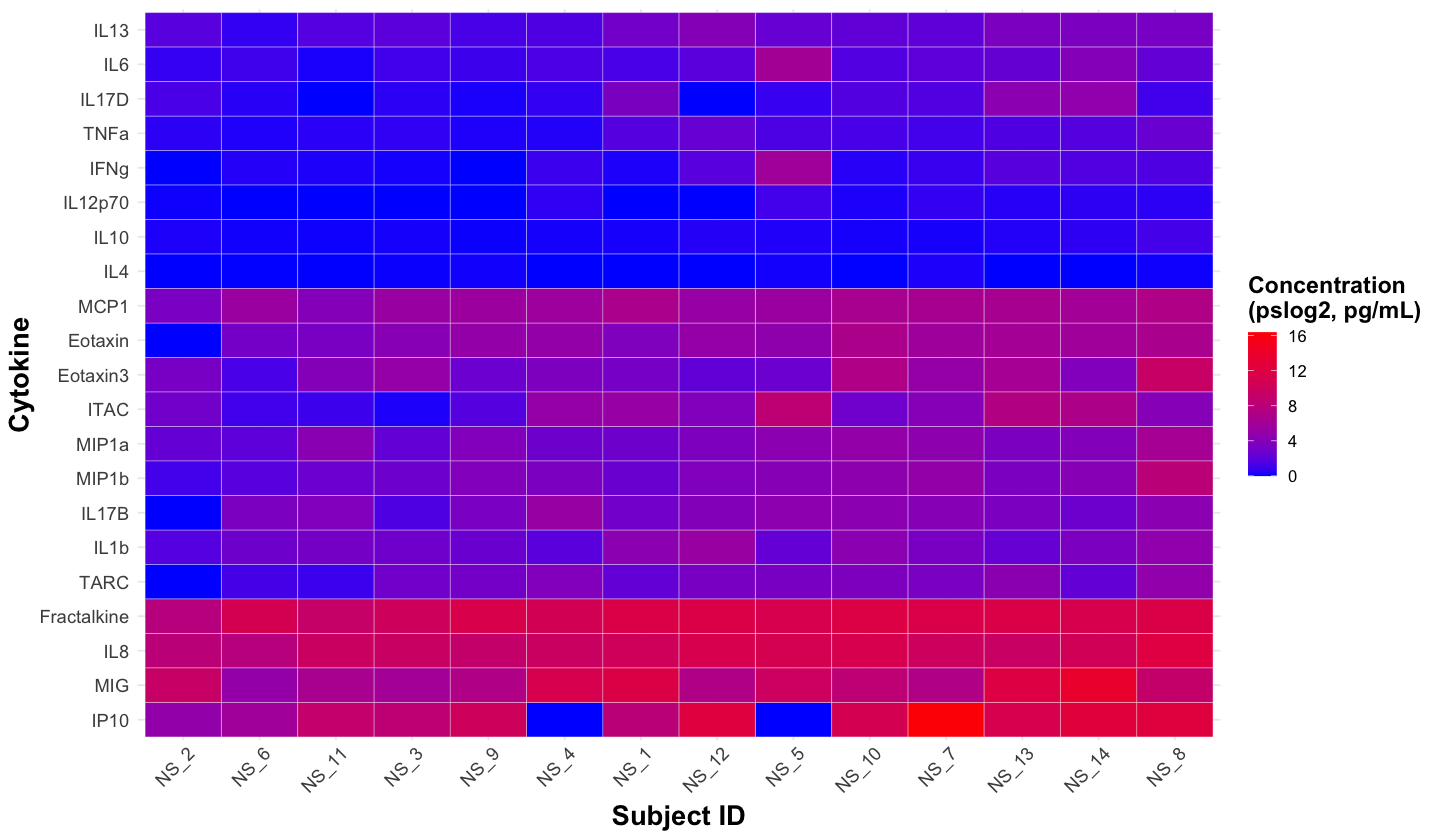

In [7]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
#without scaling

#decided to remove eigencytokines
`%notin%` <- Negate(`%in%`)
cytokines_only_df = final_df %>% filter (Name %notin% c("Cluster A", "Cluster B", "Cluster C"))

#subject ids ordered by avg cytokine conc
subject_ids = factor(cytokines_only_df$SubjectID, levels = ordered_avg_subject_ids)

#cytokines ordered by avg cytokine conc in each cluster
Cytokine_ = factor(cytokines_only_df$Name, levels = ordered_avg_cytokines)

nonscaled_heat_map = ggplot(data = cytokines_only_df, aes(x = subject_ids, y = Cytokine_, fill = Conc_pslog2)) + 
  geom_tile(color = "white") + 
  scale_fill_gradient(low = 'blue', high = 'red') + 
  theme_minimal() + 
  theme(axis.text = element_text(size = 11), #changing size of axes labels
        axis.text.x = element_text(angle = 45, hjust = 0.9), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10))+ #changes legend text

  labs(x = "Subject ID", y = "Cytokine", fill = "Concentration\n(pslog2, pg/mL)")

nonscaled_heat_map

Now adding in the eigenvector weights.

In [8]:
head(eigenvector_weights)

Protein,Cluster,Weight,Compartment,Dataset
<chr>,<chr>,<dbl>,<chr>,<chr>
Eotaxin,Cluster A,2.2520806,NLF,Original
Eotaxin3,Cluster A,0.9517359,NLF,Original
IL17B,Cluster A,-1.1148861,NLF,Original
IL1b,Cluster A,-1.5890570,NLF,Original
ITAC,Cluster A,-1.3015929,NLF,Original
MCP1,Cluster A,4.7793969,NLF,Original


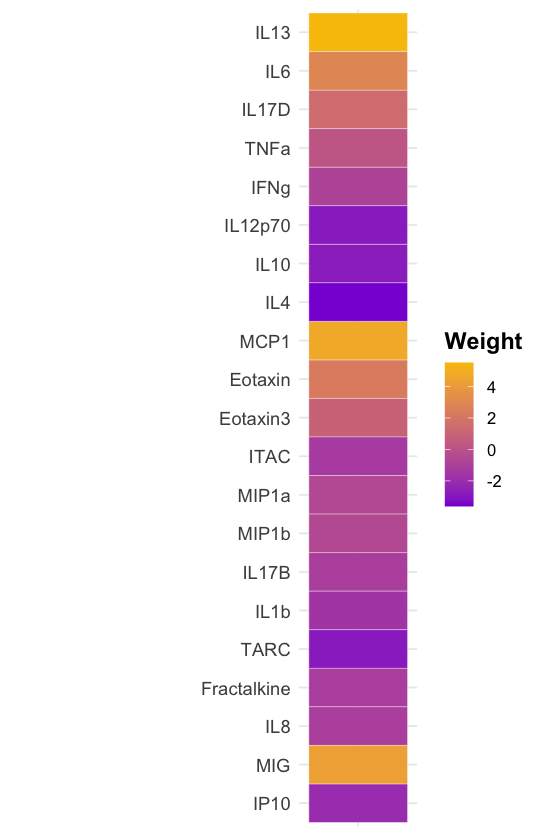

In [9]:
#this is nice, but I'll reorder the proteins based on the clusters
#also need to add in dummy variables for eigencytokines
options(repr.plot.width=4.5, repr.plot.height=7) #changing size
Cytokine = factor(eigenvector_weights$Protein, levels = c('IP10','MIG','IL8','Fractalkine', 'TARC','IL1b','IL17B',
                                            'MIP1b','MIP1a','ITAC','Eotaxin3','Eotaxin','MCP1','IL4',
                                            'IL10','IL12p70','IFNg','TNFa','IL17D','IL6','IL13'))
weights_heat_map = ggplot(data = eigenvector_weights, aes(x = Compartment, y = Cytokine, fill = Weight)) + 
  geom_tile(color = "white") + 
  theme_minimal() + 
  theme(axis.text = element_text(size = 11), #changing size of x axis labels
        axis.title.y = element_text(face = "bold", size = rel(1.5), color = 'white', 
                                    #this will create more space between the two graphs in patchwork
                                    margin = margin(r = 100)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10), #changes legend text
        axis.text.x = element_blank(), # removes x axis text
        axis.ticks.x = element_blank(), #removes x axis ticks
        axis.title.x = element_blank()) + #removes x axis title

  scale_fill_gradient(low = '#8B2AD5', high = '#F9C206')

weights_heat_map

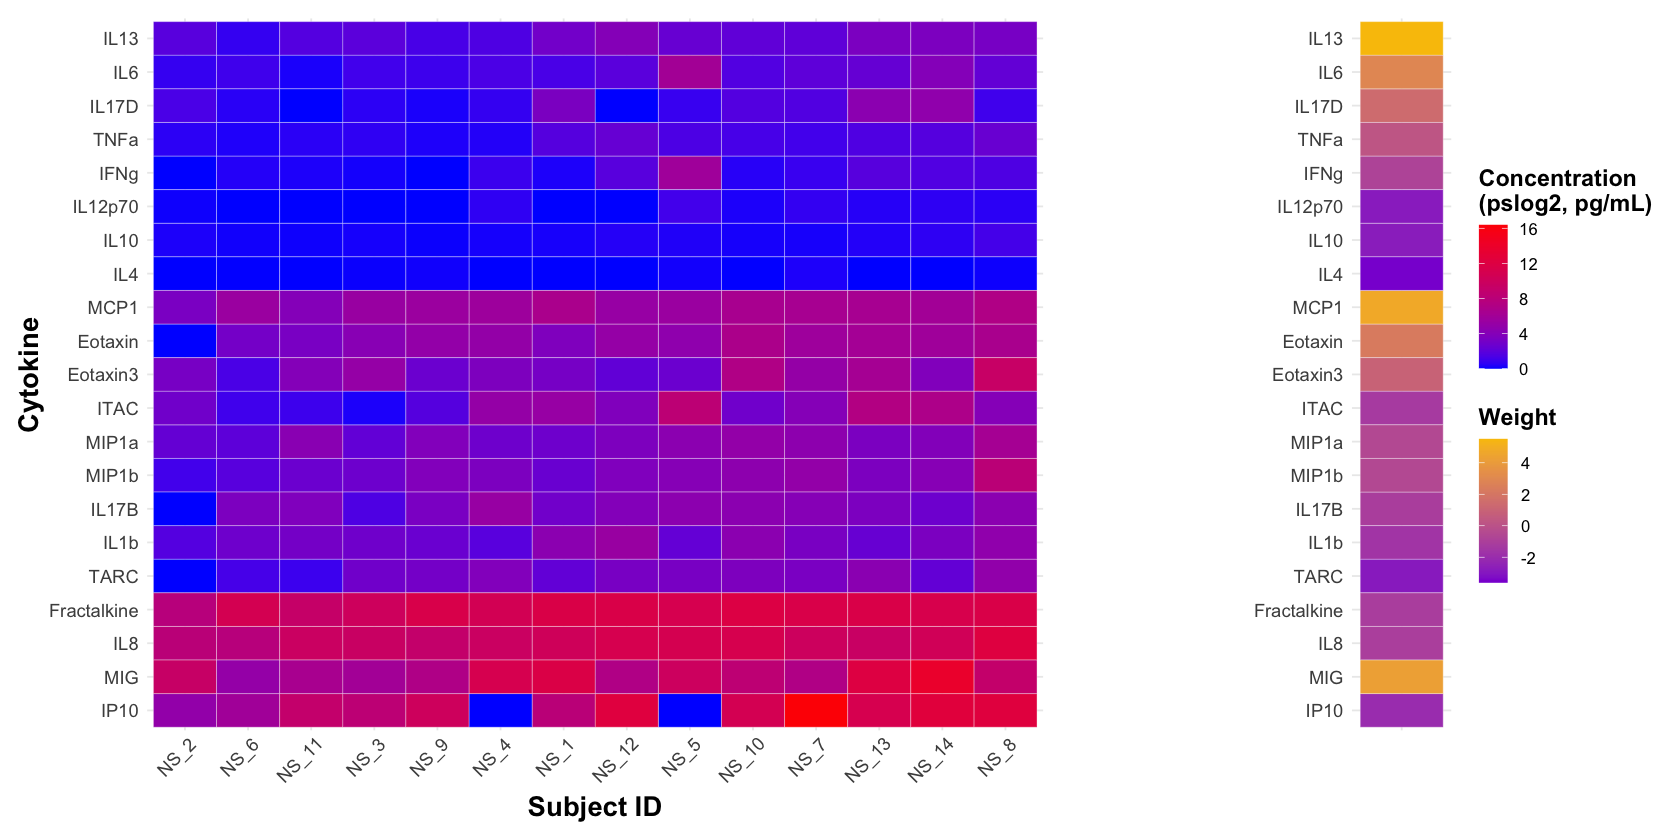

In [10]:
#putting everything together
options(repr.plot.width=14, repr.plot.height=7) #changing size
final_image = nonscaled_heat_map + weights_heat_map + plot_layout(width = c(9, 1), guides = "collect") 
final_image

In [11]:
ggsave(final_image, 
       filename = 'Figure4.pdf',
       path = Output,
       width = 14, height = 7)

# Version 2 of Figure 4

Visualizing cytokine concentrations with all subjects and only cytokines in a consensus cluster.

In [2]:
#reading in consensus clusters
consensus_clusters = data.frame(read_excel("Consensus_Clusters.xlsx"))

#cytokines df that specifies the cluster they correspond to and splitting by those clusters
cytokines_df = inner_join(cytokines %>%
    filter(Compartment == 'NLF'), consensus_clusters)  %>%
    select(SubjectID, Cluster, Group, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Group, Cluster) %>%
    group_split

cytokines_ClusterA_NS = cytokines_df[[7]] %>% 
    select(-Cluster)
cytokines_ClusterB_NS = cytokines_df[[8]] %>% 
    select(-Cluster)
cytokines_ClusterC_NS = cytokines_df[[9]] %>% 
    select(-Cluster)
cytokines_ClusterA_CS = cytokines_df[[1]] %>% 
    select(-Cluster)
cytokines_ClusterB_CS = cytokines_df[[2]] %>% 
    select(-Cluster)
cytokines_ClusterC_CS = cytokines_df[[3]] %>% 
    select(-Cluster)
cytokines_ClusterA_Ecig = cytokines_df[[4]] %>% 
    select(-Cluster)
cytokines_ClusterB_Ecig = cytokines_df[[5]] %>% 
    select(-Cluster)
cytokines_ClusterC_Ecig = cytokines_df[[6]] %>% 
    select(-Cluster)
head(cytokines_ClusterC_NS)

Joining, by = "Protein"



SubjectID,Group,Name,Conc_pslog2
<chr>,<chr>,<chr>,<dbl>
NS_1,NS,IL8,10.212021
NS_1,NS,IP10,8.062337
NS_1,NS,Fractalkine,11.587688
NS_1,NS,MIG,11.683005
NS_2,NS,IL8,8.060430
NS_2,NS,IP10,4.855869


In [3]:
#obtaining average protein concentrations grouped by cluster and saving the order into a vector for heat map
ordered_df = inner_join(cytokines, consensus_clusters) %>%
    filter(Compartment == 'NLF') %>%
    select(SubjectID, Group, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Cluster, Name) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(desc(Cluster), Avg_Conc)
ordered_avg_cytokines = ordered_df$Name
ordered_df

Joining, by = "Protein"

`summarise()` has grouped output by 'Cluster'. You can override using the `.groups` argument.



Cluster,Name,Avg_Conc
<chr>,<chr>,<dbl>
Cluster C,MIG,8.29507177
Cluster C,IP10,9.06264480
Cluster C,IL8,10.08263452
Cluster C,Fractalkine,10.88699248
Cluster B,TARC,2.46398963
Cluster B,ITAC,3.13486239
Cluster B,MIP1a,3.22528494
Cluster B,IL17B,3.33901462
Cluster B,IL1b,3.41668398


In [4]:
#getting subject id's ordered by avg concentrations grouped within smoking groups
ordered_df = inner_join(cytokines, consensus_clusters) %>%
    filter(Compartment == 'NLF') %>%
    select(SubjectID, Group, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Group, SubjectID) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Group, Avg_Conc)

ordered_df$Group = factor(ordered_df$Group, levels = c("NS", "CS", "Ecig"))
#factor didn't work so doing it manually
ordered_avg_subject_ids = c(ordered_df$SubjectID[31:44], ordered_df$SubjectID[1:13], ordered_df$SubjectID[14:30])
ordered_df

Joining, by = "Protein"

`summarise()` has grouped output by 'Group'. You can override using the `.groups` argument.



Group,SubjectID,Avg_Conc
<fct>,<chr>,<dbl>
CS,CS_15,2.787095
CS,CS_24,3.298800
CS,CS_21,3.346286
CS,CS_17,3.612406
CS,CS_26,3.641947
CS,CS_22,3.884374
CS,CS_20,3.949318
CS,CS_25,4.065228
CS,CS_18,4.197163


In [5]:
#creating final df for each cluster
final_NS_df = data.frame(rbind(cytokines_ClusterA_NS, cytokines_ClusterB_NS, cytokines_ClusterC_NS)) %>%
    #creating a space within the cluster names
    mutate(Name = ifelse(Name == "ClusterA", "Cluster A", 
           ifelse(Name == "ClusterB", "Cluster B",
           ifelse(Name == "ClusterC", "Cluster C", Name)))) %>%
    select(-Group)
final_NS_df$Group = rep("NS", times = length(final_NS_df$Name))


final_CS_df = data.frame(rbind(cytokines_ClusterA_CS, cytokines_ClusterB_CS, cytokines_ClusterC_CS)) %>%
    #creating a space within the cluster names
    mutate(Name = ifelse(Name == "ClusterA", "Cluster A", 
           ifelse(Name == "ClusterB", "Cluster B",
           ifelse(Name == "ClusterC", "Cluster C", Name)))) %>%
    select(-Group)
final_CS_df$Group = rep("CS", times = length(final_CS_df$Name))

final_Ecig_df = data.frame(rbind(cytokines_ClusterA_Ecig, cytokines_ClusterB_Ecig, cytokines_ClusterC_Ecig)) %>%
    #creating a space within the cluster names
    mutate(Name = ifelse(Name == "ClusterA", "Cluster A", 
           ifelse(Name == "ClusterB", "Cluster B",
           ifelse(Name == "ClusterC", "Cluster C", Name)))) %>%
    select(-Group)

final_Ecig_df$Group = rep("Ecig", times = length(final_Ecig_df$Name))

#combining all 
final_df = data.frame(rbind(final_NS_df, final_CS_df, final_Ecig_df))
final_df$Group = factor(final_df$Group, levels = c("NS", "CS", "Ecig"))
head(final_df)

,SubjectID,Name,Conc_pslog2,Group
,<chr>,<chr>,<dbl>,<fct>
1,NS_1,IFNg,0.2638601,NS
2,NS_1,IL10,0.1734701,NS
3,NS_1,IL12p70,0.0000000,NS
4,NS_1,TNFa,1.7227776,NS
5,NS_1,IL17D,3.4138176,NS
6,NS_1,IL4,0.0000000,NS


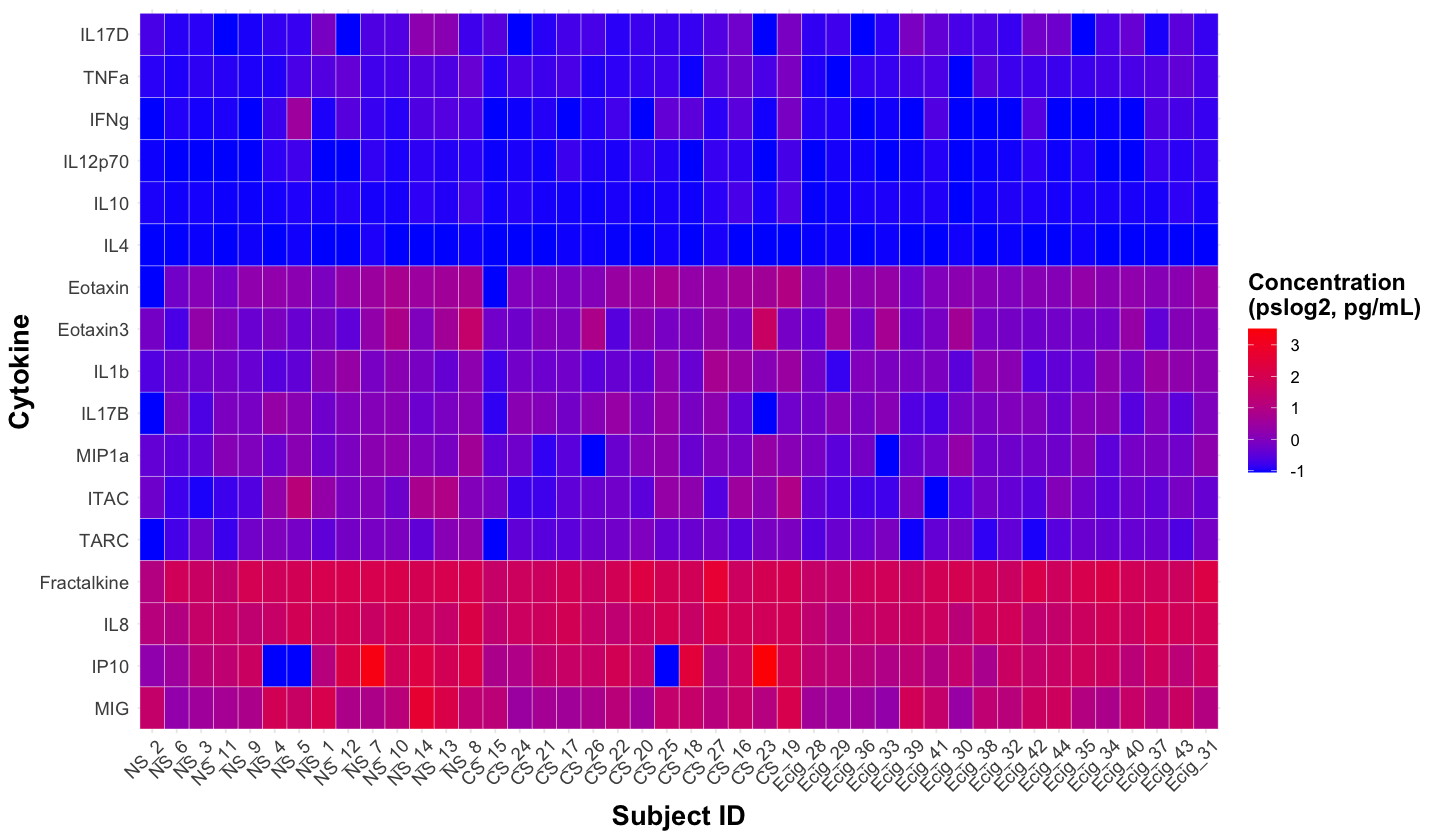

In [6]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

#subject ids ordered by avg cytokine conc
subject_ids = factor(final_df$SubjectID, levels = ordered_avg_subject_ids)

#cytokines ordered by avg cytokine conc in each cluster
Cytokine_ = factor(final_df$Name, levels = ordered_avg_cytokines)

#lastly scaling each cytokine to creating a larger visual difference between the smoking groups
Figure4_V2 = ggplot(data = final_df, aes(x = subject_ids, y = Cytokine_, fill = scale(Conc_pslog2))) + 
  geom_tile(color = "white") + 
  scale_fill_gradient(low = 'blue', high = 'red') + 
  theme_minimal() + 
  theme(axis.text = element_text(size = 11), #changing size of axes labels
        axis.text.x = element_text(angle = 45, hjust = 0.9), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10))+ #changes legend text

  labs(x = "Subject ID", y = "Cytokine", fill = "Concentration\n(pslog2, pg/mL)")

Figure4_V2